In [1]:
#!/usr/bin/env python
"""
Demo for handling your own data
--------------------------------------------------------------------------
Created December 1, 2023 for TRIPs-Py library
"""
__authors__ = "Mirjeta Pasha, Silvia Gazzola, Connor Sanderford, and Ugochukwu Obinna"
__affiliations__ = 'Tufts University, University of Bath, Arizona State University, and Tufts University'
__copyright__ = "Copyright 2023, TRIPs-Py library"
__license__ = "GPL"
__version__ = "1.0"
__email__ = "mirjeta.pasha@tufts.edu; mirjeta.pasha1@gmail.com; sg968@bath.ac.uk; csanderf@asu.edu; connorsanderford@gmail.com; Ugochukwu.Ugwu@tufts.edu"

In [5]:
import time
import matplotlib.pyplot as plt
import astra
import trips.utilities.phantoms as phantom
from trips.test_problems.Deblurring import *
from trips.utilities.operators import *
from trips.utilities.helpers import *
from trips.solvers.GKS import *
from trips.solvers.MMGKS import *
from trips.solvers.Tikhonov import *
from trips.solvers.tSVD import *
from trips.solvers.Hybrid_GMRES import *
from trips.solvers.Hybrid_LSQR import *
from trips.utilities.helpers import convert_image_for_trips

##### In this notebook we illustrate how to use functionalities of the package if you have your own data stored as .mat file


#### Step 1: Make sure to create a folder my_image_data inside the data folder under demos if it does not exist.

#### Step 2: Place your image(s) that you would like to use in the folder my_image_data

#### Step 3: Run the following code to generate the data in the format that can be used in the test problems of TRIPs-Py

#### Run convert_image_for_trips(imag = 'name_of_the_image', image_type = 'type_of_th_image)

In [6]:
# Running the function convert_image_for_trips(imag = 'name_of_the_image', image_type = 'type_of_th_image)
# will save your data as name_of_the_image.mat that can be used from the other functionalities
convert_image_for_trips(imag = 'sky', image_type= 'jpg')

##### Once the above function is finished, check that there exist a file name_of_the_image.mat in the folder demos/image_data

##### Now all the other steps of generating the test problem should work the same as for the case when the data are given in the package.

In [8]:
# Deblurring example test problem
Deblur = Deblurring(CommitCrime = False)
nx = 64 # Define the first dimension of the image
ny = 64 # Define the second dimension of the image
spread = 1 # The PSF parameter
im = 'sky' #The choice of the image:
# Options for the choice of the image are Himage, satellite64, satellite128, edges
shape = (nx, ny)
spreadnew = (spread, spread)
A = Deblur.forward_Op([10, 10], spreadnew, nx, ny)
x_true = Deblur.gen_true_mydata(im, nx = nx, ny = ny)
b_true = Deblur.gen_data(x_true)
(b, delta) = Deblur.add_noise(b_true, opt = 'Gaussian', noise_level = 0.01)

data already in the path.


###### Display the true image, the blurred image, and the blurred and noisy image

(<AxesSubplot:title={'center':'b'}>,
 Text(0.5, 1.0, 'b'),
 (0.0, 1.0, 0.0, 1.0),
 <matplotlib.image.AxesImage at 0x7ffc887b3160>)

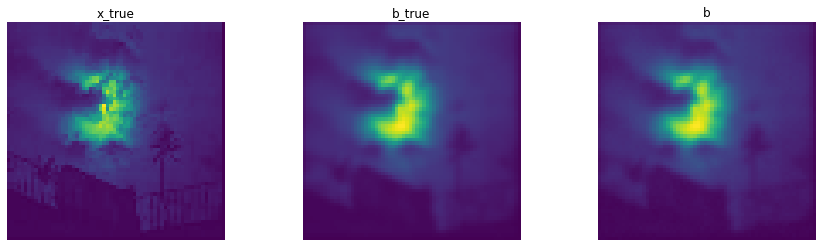

In [9]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1), plt.title('x_true'), plt.axis('off'), plt.imshow(x_true.reshape((nx,ny)))
plt.subplot(1,3,2), plt.title('b_true'), plt.axis('off'), plt.imshow(b_true.reshape((nx, ny)))
plt.subplot(1,3,3), plt.title('b'), plt.axis('off'), plt.imshow(b.reshape((nx, ny)))

##### 1.1. Compute the SVD of the operartor $A$ and plot the singlar values and the singular vectors
###### If the parameter is 'A' then we give the full operator to the function plot_singular_values_svd. The SVD is then computed and the singlar values are plotted. If the parameter is 'S' then we have precomputed the SVD from which we have S and the function plot_singular_values_svd will only plot the singular values. The same applies for plotting the singular vectors. If the operaror is not given, we give the matrix V.

In [10]:
# If the operator is sparse, we convert it to dense A.todense()
plot_singular_values_svd(Operator = A , parameter = 'A')
# If the operator is in the matrix form, but very large and sparse, the following commands can be used to compute the SVD
# import scipy
# [U, S, V] = scipy.sparse.linalg.svds(A, 100)
# 100 defines the number of singular values to be computed

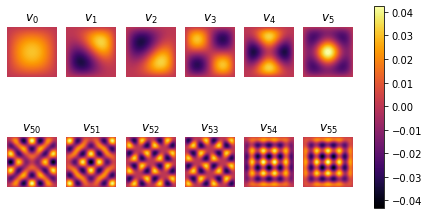

In [53]:
plot_singular_vectors_svd(Operator = A, size = nx, parameter = 'A')

##### 1.1. Compute the truncated SVD solution of a problem by specifying how many singular values you want to keep after truncation

(-0.5, 63.5, 63.5, -0.5)

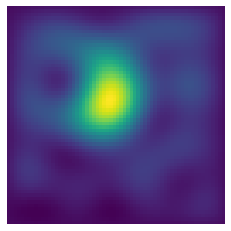

In [54]:
truncated_value = 40
b_vec = b.reshape((-1,1))
x_tsvd = TruncatedSVD_sol(A, truncated_value, b_vec)
plt.imshow(x_tsvd.reshape((nx, ny)))
plt.axis('off')

#### 1.2 Compute an approximate solution by using Generalized Krylov Subspace method (GKS)

In [55]:
# First we compute a naive solution
x_naive = A.T@b.reshape((-1,1))

In [56]:
# Define a derivative operator as a regularization operator
L = spatial_derivative_operator(nx, ny, 1)
data_vec = b.reshape((-1,1))
# Use GKS to compute an approximate solution
(x_gks, info) = GKS(A, data_vec, L, projection_dim=2, n_iter = 20, regparam = 'gcv', x_true = x_true.reshape(-1,1), delta = delta)

running GKS...: 100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


(<AxesSubplot:title={'center':'x_gks'}>,
 Text(0.5, 1.0, 'x_gks'),
 (0.0, 1.0, 0.0, 1.0),
 <matplotlib.image.AxesImage at 0x7fcc07422340>)

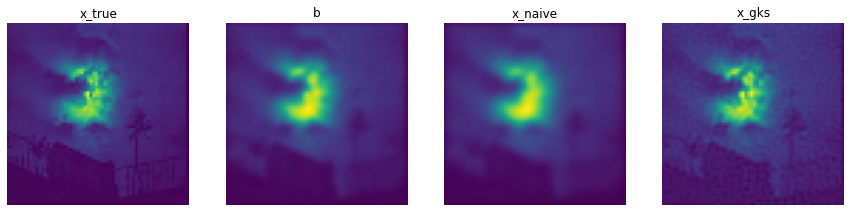

In [57]:
# Display the true desired vs the naive computed solution and vs the approximate regularized computed solution 
plt.figure(figsize=(15,4))
plt.subplot(1,4,1), plt.title('x_true'), plt.axis('off'), plt.imshow(x_true.reshape((nx,ny)))
plt.subplot(1,4,2), plt.title('b'), plt.axis('off'), plt.imshow(b.reshape((nx,ny)))
plt.subplot(1,4,3), plt.title('x_naive'), plt.axis('off'), plt.imshow(x_naive.reshape((nx,ny)))
plt.subplot(1,4,4), plt.title('x_gks'), plt.axis('off'), plt.imshow(x_gks.reshape((nx, ny)))